# Time Series Synthesis with Irregular Data

In this tutorial, we will demonstrate how to synthesize time series, given irregular time series. 

## Problem setting
Standard time series synthesis assumes that time series data are regularly sampled, i.e. a time series window $\mathbf{x} \in \mathbb{R}^{T \times D}$, where $T$ is series length and $D$ is channels.

Regularly sampled, $\mathbf{x} = [x_1, x_2, \cdots, x_T]$, is evenly spaced. However, some time series data may have missing time steps, or naturally unevenly measured (e.g. patient health measurements). 

Then, how to generate complete T-step time series with irregular data? `GenTS` implement KoVAE, GTGAN, and neural differential equation-based models for such task.

## Implementation
### 1. import modules

In [1]:
import torch
from gents.dataset import Spiral2D
from gents.model import KoVAE
from lightning import Trainer
from gents.evaluation import tsne_visual
from gents.evaluation import context_fid
import matplotlib.pyplot as plt

/home/wcx/anaconda3/envs/gents/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
CUDA extension for cauchy multiplication not found. Install by going to extensions/cauchy/ and running `python setup.py install`. This should speed up end-to-end training by 10-50%
Falling back on slow Cauchy kernel. Install at least one of pykeops or the CUDA extension for efficiency.
Falling back on slow Vandermonde kernel. Install pykeops for improved memory efficiency.


### 2. setup datamodule and model
Here, we set `irregular_droput=0.2` in `Spiral2D` to manually build a irregular dataset. This will randomly mark some time steps as *missing*, and render a `data_mask` for each batch. 

For `KoVAE` and `GTGAN`, they need pre-interpolation coefficients for training, thus we need to add coeffs in datamodule by `add_coeffs='cubic_spline'`.

We set $T=24$ for illustration.

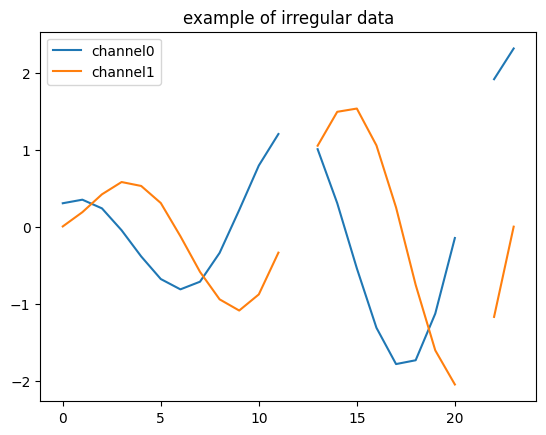

In [2]:
dm = Spiral2D(
    seq_len=24,
    batch_size=64,
    num_samples=1000,
    data_dir="../data",
    irregular_dropout=0.1,
    add_coeffs='cubic_spline'
)
model = KoVAE(
    seq_len=dm.seq_len,
    seq_dim=dm.seq_dim,
    irregular_ts=True
)

# show data
dm.prepare_data()
dm.setup("fit")
full_data = next(iter(dm.train_dataloader()))["seq"]
data_mask = next(iter(dm.train_dataloader()))["data_mask"]
fig, ax = plt.subplots(1)
ax.plot(
    full_data.masked_fill(~data_mask, float("nan"))[0, :, :],
    label=["channel0", "channel1"],
)
ax.set_title("example of irregular data")
ax.legend()

In [3]:
trainer = Trainer(max_epochs=500, devices=[0], enable_progress_bar=False)
trainer.fit(model, dm)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name           | Type               | Params | Mode 
--------------------------------------------------------------
0 | encoder        | VKEncoderIrregular | 7.7 K  | train
1 | decoder        | VKDecoder          | 19.5 K | train
2 | z_prior_gru    | GRUCell            | 2.3 K  | train
3 | z_prior_mean   | Linear             | 336    | train
4 | z_prior_logvar | Linear             | 336    | train
5 | z_mean         | Linear             | 656    | train
6 | z_

### 3. Evaluation
Qualitative evaluation: TSNE visualization

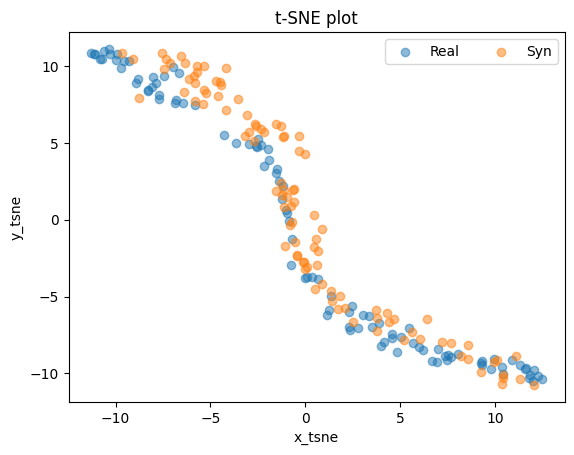

In [4]:
# testing
dm.setup("test")
full_data = torch.cat([batch["seq"] for batch in dm.test_dataloader()])
# generate samples with the same number as real data
gen_data = model.sample(n_sample=len(full_data)) 
tsne_visual(full_data, gen_data)

generated full-step time series V.S. real full-step data

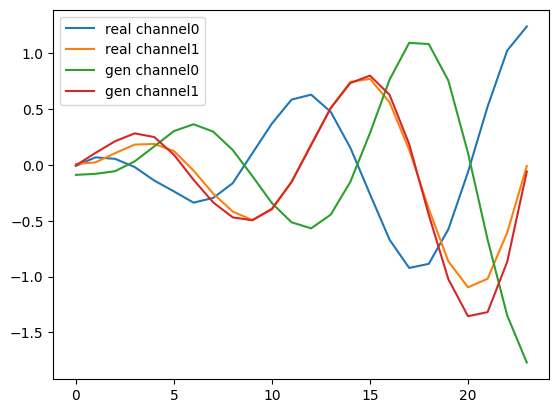

In [5]:
plt.plot(full_data[0], label=['real channel0', 'real channel1'])
plt.plot(gen_data[0], label=['gen channel0', 'gen channel1'])
plt.legend()

Quantitative evaluation: context-fid

In [6]:
context_fid(full_data.numpy(), gen_data.numpy(), device="cuda:0", train_data=dm.train_ds.data.numpy())

train a new ts2vec model


np.float64(0.6277645451550916)